In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2

import torchvision.transforms as T
from torchvision.datasets import VOCDetection
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision
import torch
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.ops import box_iou
from sklearn.metrics import precision_score, recall_score
import numpy as np
import torch

from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchmetrics.detection import IntersectionOverUnion
from torchmetrics.classification import MulticlassAveragePrecision, MulticlassRecall

torch.backends.cudnn.benchmark = True

In [3]:
NUM_CPU = os.cpu_count()
print(NUM_CPU)

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

voc_classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
               'dog', 'horse', 'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

voc_class_to_id = {name: i for i, name in enumerate(voc_classes)}


def target_transform(voc_dict):
    anno = voc_dict['annotation']
    boxes = []
    labels = []

    x_scale = 224 / int(anno['size']['width'])
    y_scale = 224 / int(anno['size']['height'])

    for obj in anno['object']:
        bbox = obj['bndbox']
        boxes.append([
            int(int(bbox['xmin']) * x_scale),
            int(int(bbox['ymin']) * y_scale),
            int(int(bbox['xmax']) * x_scale),
            int(int(bbox['ymax']) * y_scale)
        ])
        labels.append(voc_class_to_id[obj['name']])

    return {
        'boxes': torch.tensor(boxes, dtype=torch.float32),
        'labels': torch.tensor(labels, dtype=torch.int64)
    }

dataset = VOCDetection(
    root='data/',
    year='2012',
    image_set='train',
    download=True,
    transform=transform,
    target_transform=target_transform
)

val_dataset = VOCDetection(
    root='data/',
    year='2012',
    image_set='val',
    download=True,
    transform=transform,
    target_transform=target_transform
)


2


100%|██████████| 2.00G/2.00G [01:46<00:00, 18.7MB/s]


In [4]:
dataloader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=NUM_CPU,
    pin_memory=True,
    collate_fn=lambda batch: (list(zip(*batch))[0], list(zip(*batch))[1])
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=NUM_CPU,
    pin_memory=True,
    collate_fn=lambda batch: (list(zip(*batch))[0], list(zip(*batch))[1])
)

In [5]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280

anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),) * 5)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=21,  # 20 класів + фон
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 173MB/s]


Налаштуємо оптимізатор, scheduler та проведемо дотренування моделі:

In [23]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Scheduler для зменшення коефіцієнта навчання
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
scaler = GradScaler()
optimizer = torch.optim.SGD(
    [p for p in model.parameters() if p.requires_grad],
    lr=0.005, momentum=0.9, weight_decay=0.0005
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

history = []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    model.train()
    running_loss = 0.0

    for i, (images, targets) in enumerate(dataloader):
        # print(i)
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += losses.item()
        if (i + 1) % 100 == 0:
            print(f"Step {i+1}/{len(dataloader)}, Loss: {running_loss/(i + 1):.4f}")

    lr_scheduler.step()
    avg_loss = running_loss / len(dataloader)

    map = MeanAveragePrecision()
    iou = IntersectionOverUnion()

    model.eval()
    with torch.no_grad():
      for i, (images, targets) in enumerate(val_dataloader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        preds = model(images)

        map.update(preds, targets)
        iou.update(preds, targets)

    map_dict = map.compute()
    map = map_dict['map'].item()
    p = map_dict['map_per_class']#.item()
    r = map_dict['mar_10'].item()
    iou = iou.compute()['iou'].item()

    print(f"Epoch {epoch+1} done. Avg Loss: {avg_loss:.4f}\n")
    print(f"mAP: {map}, Precision (per class): {p}, mAR: {r}, IoU: {iou}")

    history.append({
        'avg_loss': avg_loss,
        'map': map,
        'map_per_class': p,
        'mar': r,
        'iou': iou
    })

Epoch 1/10


<ipython-input-23-fad17b26146a>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-23-fad17b26146a>:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Step 100/715, Loss: 0.4935
Step 200/715, Loss: 0.4857
Step 300/715, Loss: 0.4817
Step 400/715, Loss: 0.4772
Step 500/715, Loss: 0.4739
Step 600/715, Loss: 0.4650
Step 700/715, Loss: 0.4636
Epoch 1 done. Avg Loss: 0.4633

mAP: 0.11159007251262665, Precision (per class): -1.0, mAR: 0.2981497645378113, IoU: 0.13434694707393646
Epoch 2/10
Step 100/715, Loss: 0.4378
Step 200/715, Loss: 0.4341
Step 300/715, Loss: 0.4270
Step 400/715, Loss: 0.4208
Step 500/715, Loss: 0.4204
Step 600/715, Loss: 0.4198
Step 700/715, Loss: 0.4190
Epoch 2 done. Avg Loss: 0.4194

mAP: 0.16568927466869354, Precision (per class): -1.0, mAR: 0.32831889390945435, IoU: 0.15335218608379364
Epoch 3/10
Step 100/715, Loss: 0.4036
Step 200/715, Loss: 0.3881
Step 300/715, Loss: 0.3835
Step 400/715, Loss: 0.3851
Step 500/715, Loss: 0.3847
Step 600/715, Loss: 0.3884
Step 700/715, Loss: 0.3887
Epoch 3 done. Avg Loss: 0.3885

mAP: 0.17761346697807312, Precision (per class): -1.0, mAR: 0.3516736924648285, IoU: 0.1363709419965744


KeyboardInterrupt: 

In [24]:
history

[{'avg_loss': 0.4632556047264513,
  'map': 0.11159007251262665,
  'map_per_class': tensor(-1.),
  'mar': 0.2981497645378113,
  'iou': 0.13434694707393646},
 {'avg_loss': 0.41944092026540447,
  'map': 0.16568927466869354,
  'map_per_class': tensor(-1.),
  'mar': 0.32831889390945435,
  'iou': 0.15335218608379364},
 {'avg_loss': 0.3885442859851397,
  'map': 0.17761346697807312,
  'map_per_class': tensor(-1.),
  'mar': 0.3516736924648285,
  'iou': 0.1363709419965744},
 {'avg_loss': 0.35501910058351666,
  'map': 0.21964281797409058,
  'map_per_class': tensor(-1.),
  'mar': 0.37678298354148865,
  'iou': 0.1367466300725937},
 {'avg_loss': 0.3519274342101771,
  'map': 0.21982014179229736,
  'map_per_class': tensor(-1.),
  'mar': 0.3768111765384674,
  'iou': 0.13743183016777039}]

In [25]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidu

In [26]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])

    bb = out[1]['boxes'].numpy().astype(int)

    with torch.no_grad():
      pred_bb = model(torch.tensor(image.transpose((2,0,1))).unsqueeze(0).to(device))[0]['boxes']
      pred_bb = pred_bb.cpu().numpy().astype(int)

    image = np.ascontiguousarray(image)
    for i in bb:
        cv2.rectangle(image, sorted([i[0],i[1]]), sorted([i[2],i[3]]), (0,255,0), thickness=2)

    for i in pred_bb:
        cv2.rectangle(image, sorted([i[0],i[1]]), sorted([i[2],i[3]]), (0,0,255), thickness=2)

    plt.figure(figsize=(10,10))
    plt.imshow(image)

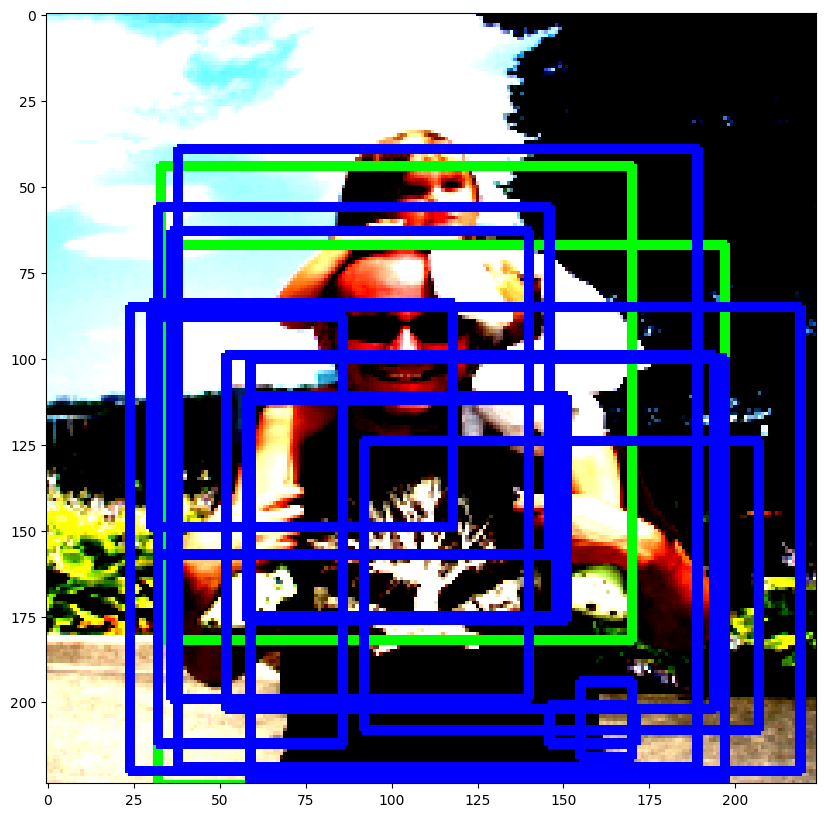

In [27]:
plot_img(val_dataset, 101)

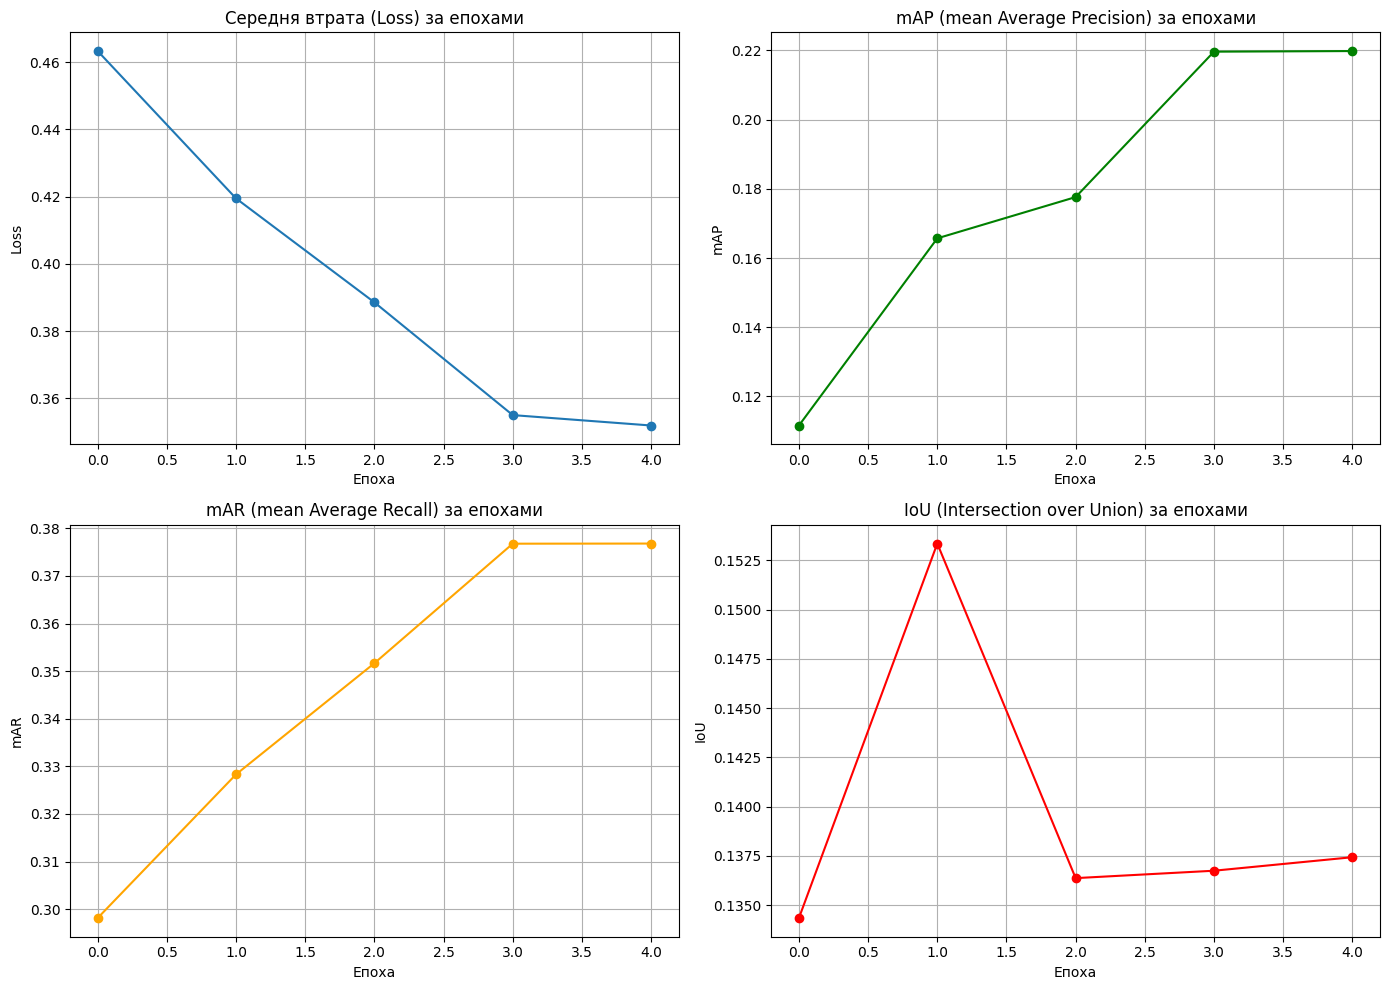

In [28]:
metrics = {key: [epoch[key] for epoch in history] for key in history[0]}

plt.figure(figsize=(14, 10))

# Втрата (Loss)
plt.subplot(2, 2, 1)
plt.plot(metrics['avg_loss'], marker='o')
plt.title('Середня втрата (Loss) за епохами')
plt.xlabel('Епоха')
plt.ylabel('Loss')
plt.grid(True)

# mAP
plt.subplot(2, 2, 2)
plt.plot(metrics['map'], marker='o', color='green')
plt.title('mAP (mean Average Precision) за епохами')
plt.xlabel('Епоха')
plt.ylabel('mAP')
plt.grid(True)

# mAR
plt.subplot(2, 2, 3)
plt.plot(metrics['mar'], marker='o', color='orange')
plt.title('mAR (mean Average Recall) за епохами')
plt.xlabel('Епоха')
plt.ylabel('mAR')
plt.grid(True)

# IoU
plt.subplot(2, 2, 4)
plt.plot(metrics['iou'], marker='o', color='red')
plt.title('IoU (Intersection over Union) за епохами')
plt.xlabel('Епоха')
plt.ylabel('IoU')
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:

def compute_iou(pred_boxes, true_boxes):
    ious = box_iou(pred_boxes, true_boxes)
    return ious

def compute_precision_recall(pred_boxes, true_boxes, iou_threshold=0.5):
    if len(pred_boxes) == 0:
        return 0, 0
    ious = compute_iou(pred_boxes, true_boxes)
    matches = ious > iou_threshold
    tp = matches.sum().item()
    fp = len(pred_boxes) - tp
    fn = len(true_boxes) - tp
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return precision, recall

def compute_map(pred_boxes_list, true_boxes_list, iou_threshold=0.5):
    precisions, recalls = [], []
    for pred_boxes, true_boxes in zip(pred_boxes_list, true_boxes_list):
        precision, recall = compute_precision_recall(pred_boxes, true_boxes, iou_threshold)
        precisions.append(precision)
        recalls.append(recall)
    return np.mean(precisions), np.mean(recalls)


In [30]:

def plot_boxes(image, true_boxes, pred_boxes, figsize=(8, 8)):
    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image.permute(1, 2, 0).cpu())
    for box in true_boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                 edgecolor='green', facecolor='none', label='Ground Truth')
        ax.add_patch(rect)
    for box in pred_boxes:
        x1, y1, x2, y2 = box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                 edgecolor='red', facecolor='none', label='Prediction')
        ax.add_patch(rect)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    plt.axis('off')
    plt.show()


In [31]:

def analyze_errors(pred_boxes, true_boxes, iou_threshold=0.5):
    ious = compute_iou(pred_boxes, true_boxes)
    false_positives = []
    false_negatives = []
    for i, pred in enumerate(pred_boxes):
        if (ious[i] < iou_threshold).all():
            false_positives.append(pred)
    for j, gt in enumerate(true_boxes):
        if (ious[:, j] < iou_threshold).all():
            false_negatives.append(gt)
    print(f"False Positives: {len(false_positives)}")
    print(f"False Negatives: {len(false_negatives)}")
    return false_positives, false_negatives


In [32]:
def analyze_img(data,idx):
  out = data.__getitem__(idx)
  image = out[0].cpu()

  # image = torch.rand(3, 224, 224)
  true_boxes = out[1]['boxes'].cpu()
  with torch.no_grad():
    pred_boxes = model(image.unsqueeze(0).to(device))[0]['boxes'].cpu()

  plot_boxes(image, true_boxes, pred_boxes)

  precision, recall = compute_precision_recall(pred_boxes, true_boxes)
  print(f"Precision: {precision:.2f}, Recall: {recall:.2f}")

  map_score, recall_score = compute_map([pred_boxes], [true_boxes])
  print(f"mAP: {map_score:.2f}, Mean Recall: {recall_score:.2f}")

  false_positives, false_negatives = analyze_errors(pred_boxes, true_boxes)

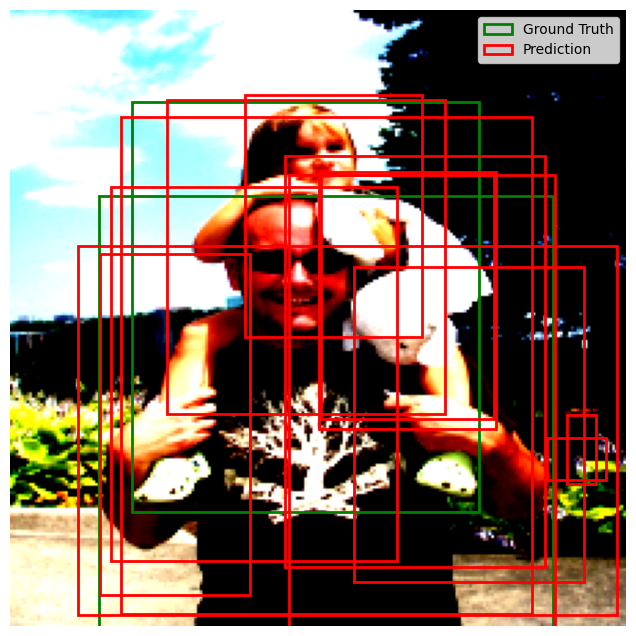

Precision: 0.54, Recall: 3.50
mAP: 0.54, Mean Recall: 3.50
False Positives: 8
False Negatives: 0


In [33]:
analyze_img(val_dataset, 101)

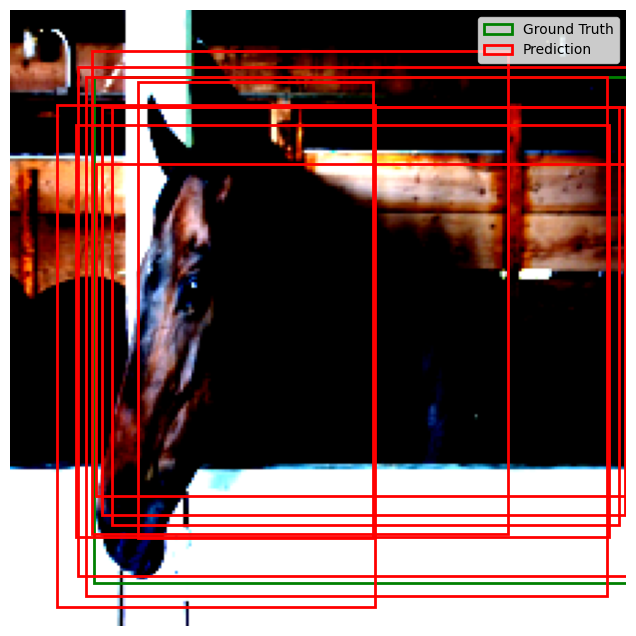

Precision: 0.78, Recall: 7.00
mAP: 0.78, Mean Recall: 7.00
False Positives: 2
False Negatives: 0


In [34]:
analyze_img(val_dataset, 23)

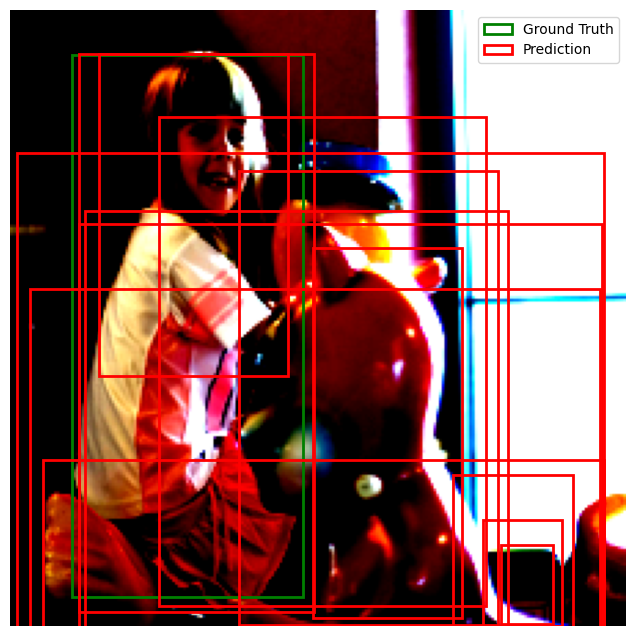

Precision: 0.08, Recall: 1.00
mAP: 0.08, Mean Recall: 1.00
False Positives: 12
False Negatives: 0


In [35]:
analyze_img(val_dataset, 228)

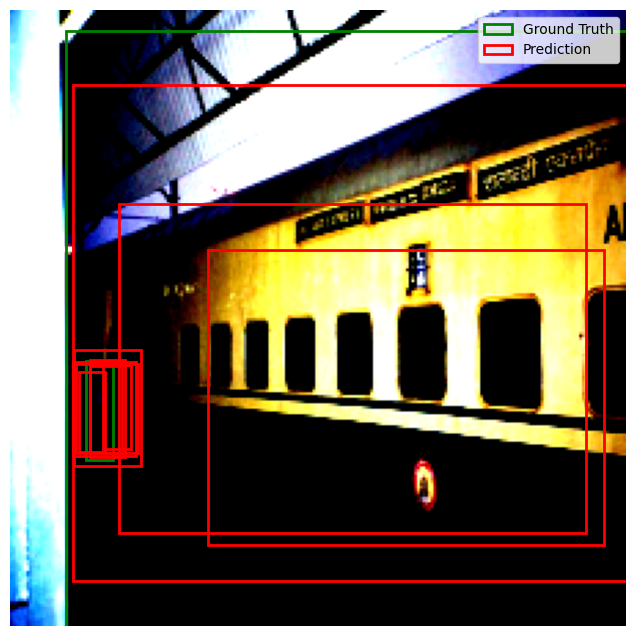

Precision: 0.30, Recall: 1.50
mAP: 0.30, Mean Recall: 1.50
False Positives: 7
False Negatives: 0


In [36]:
analyze_img(val_dataset, 1)

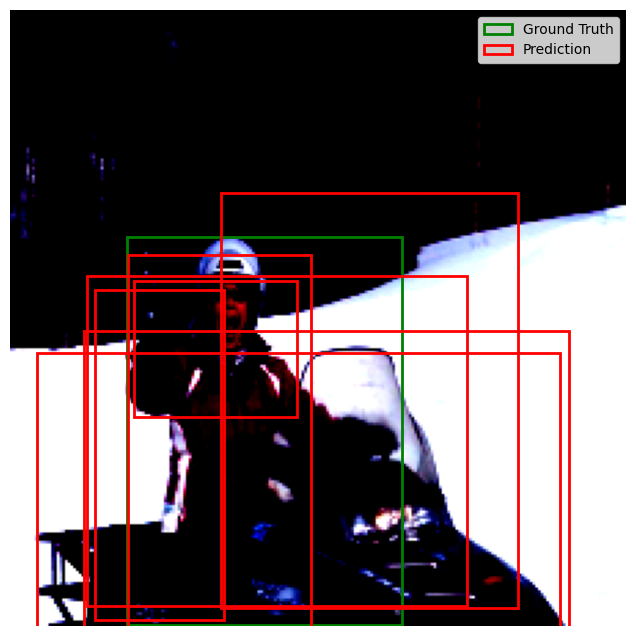

Precision: 0.29, Recall: 2.00
mAP: 0.29, Mean Recall: 2.00
False Positives: 5
False Negatives: 0


In [37]:
analyze_img(val_dataset, 76)

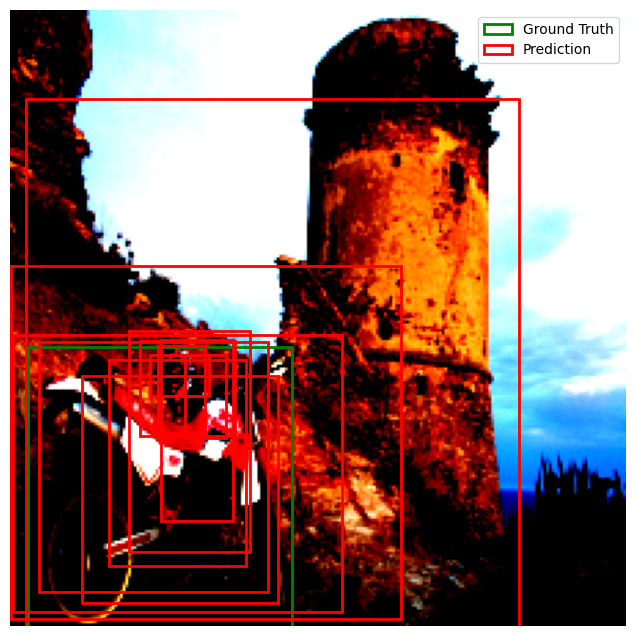

Precision: 0.33, Recall: 4.00
mAP: 0.33, Mean Recall: 4.00
False Positives: 8
False Negatives: 0


In [38]:
analyze_img(val_dataset, 92)

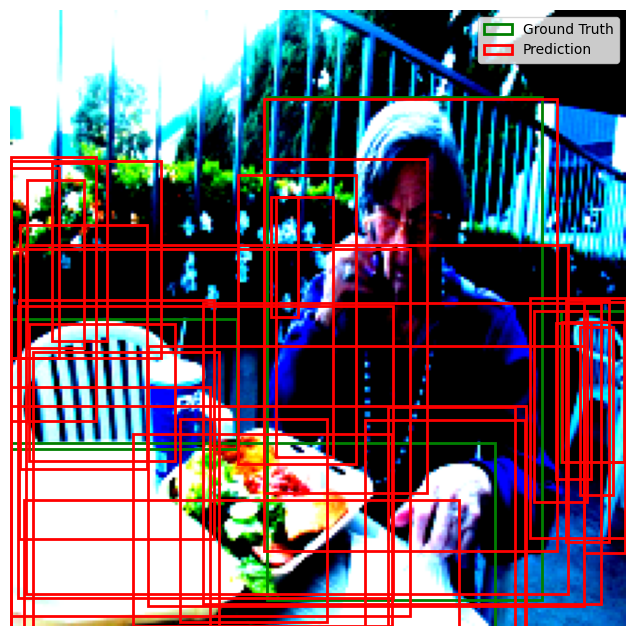

Precision: 0.18, Recall: 1.50
mAP: 0.18, Mean Recall: 1.50
False Positives: 27
False Negatives: 0


In [39]:
analyze_img(val_dataset, 420)